<a href="https://www.kaggle.com/code/mrafraim/dl-day-26-simple-rnn-in-pytorch?scriptVersionId=290346629" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Day 26: Simple RNN in PyTorch

Today you’ll learn:
1. How PyTorch implements a vanilla RNN
2. How sequence data is shaped for RNNs
3. What hidden state looks like in code
4. Manual sequence prediction using RNN
5. Forward pass through time (step-by-step intuition)
6. How outputs are generated from hidden states

If you found this notebook helpful, your **<b style="color:red;">UPVOTE</b>** would be greatly appreciated! It helps others discover the work and supports continuous improvement.

---

# Problem Setup: Sequence Prediction

We will use a toy sequence problem:

Input sequence:
$$[1, 2, 3, 4]$$

Target:
Predict the next value → 5

This is NOT about performance. 
This is about understanding how RNN processes sequences.


# Import Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Prepare Sequence Data

In [2]:
# Input sequence (batch_size=1, sequence_length=4, input_size=1)
# Batch size = 1 → one sequence
# Sequence length = 4 → four time steps
# Input size = 1 → one feature per time step

sequence = torch.tensor([[[1.0], [2.0], [3.0], [4.0]]])

# Target value (batch = 1, output_size = 1)
target = torch.tensor([[5.0]])

print("Sequence shape: ",sequence.shape)
print("Target shape: ",target.shape) 

Sequence shape:  torch.Size([1, 4, 1])
Target shape:  torch.Size([1, 1])


- Single sequence → $[[[x1], [x2], ...]]$ → shape [batch, seq_len, input_size]
- Single scalar target → $[[value]]$ → shape [batch, output_size]

# Define a Simple RNN Model

In [3]:
class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # RNN layer: input_size=1, hidden_size=8, batch_first=True
        self.rnn = nn.RNN(
            input_size=1,      # each time step has 1 feature
            hidden_size=8,     # hidden size = 8 memory slots
            batch_first=True
        )

        # Fully connected layer: hidden_size → 1
        self.fc = nn.Linear(8, 1)

    def forward(self, x):

        # out: hidden states for all time steps
        # h_n: hidden state of last time step
        out, h_n = self.rnn(x)      # out: all time steps
        last_out = out[:, -1, :]    # take last time step
        output = self.fc(last_out)  # map hidden state → prediction
        return output, h_n


<u>**1. Class Definition**</u>

```python
class SimpleRNN(nn.Module):
````

* You are defining a custom neural network
* `nn.Module` is the base class for all PyTorch models
* Every PyTorch model must:

  * inherit from `nn.Module`
  * implement `__init__`
  * implement `forward`

Think of this class as a blueprint of your RNN.


**Constructor (`__init__`)**

```python
def __init__(self):
    super().__init__()
```

* Initializes the parent `nn.Module`
* Without this, PyTorch cannot track parameters
* This enables:

  * `model.parameters()`
  * backpropagation
  * `.to(device)`


<u>**2. RNN Layer**</u>

```python
self.rnn = nn.RNN(
    input_size=1,
    hidden_size=8,
    batch_first=True
)
```

```
Time steps →  t1    t2    t3    t4
               │     │     │     │
               ▼     ▼     ▼     ▼
          ┌─────── RNN CELL ───────┐
          │  h1     h2     h3  h4  │  ← RNN LAYER (all cells together)
          └────────────────────────┘
```

`input_size=1`

* Each time step has 1 feature
* Your input shape must be:

  ```
  (batch_size, sequence_length, 1)
  ```
* Example time step:

  ```
  x_t = [2.0]
  ```

`hidden_size=8`

* The RNN remembers 8 numbers per time step
* Hidden state shape:

  ```
  h_t ∈ ℝ⁸
  ```
* Bigger hidden size = more memory capacity


`batch_first=True`

* Input format:

  ```
  (batch, time, features)
  ```
* Easier to think about than default PyTorch order


<u>**3. What this RNN layer does conceptually**</u>

At each time step:

```
x_t + h_{t-1} → RNN Cell → h_t
```

It produces:

* `out` → hidden states for all time steps
* `h_n` → hidden state of the last time step


<u>**4. Fully Connected Layer**</u>

```python
self.fc = nn.Linear(8, 1)
```

* Takes the RNN memory (size 8)
* Converts it into final prediction
* Mapping:

  ```
  ℝ⁸ → ℝ¹
  ```

Why needed?

> RNN learns temporal patterns, but Linear layer makes the final decision


<u>**5. Forward Pass**</u>

```python
def forward(self, x):
```

* Defines how data flows through the network
* PyTorch automatically calls this when you do:

  ```python
  model(x)
  ```

<u>**6️. RNN Forward Execution**</u>

```python
out, h_n = self.rnn(x)
```

Shapes:

If:

```
x.shape = (1, 4, 1)
```

Then:

```
out.shape = (1, 4, 8)
h_n.shape = (1, 1, 8)
```
Meaning:

* `out` → hidden state at every time step
* `h_n` → hidden state at final time step


<u>**7. Selecting the Last Time Step**</u>

```python
last_out = out[:, -1, :]
```

Why?

* Many tasks (forecasting, classification) only care about the final summary
* `-1` means last time step

Shape:

```
last_out.shape = (batch_size, hidden_size)
→ (1, 8)
```

<u>**8. Final Prediction Layer**</u>

```python
output = self.fc(last_out)
```

* Converts RNN memory → prediction
* Shape:

  ```
  (1, 8) → (1, 1)
  ```

This is your final model output


<u>**9. Return Values**</u>

```python
return output, h_n
```

* `output` → prediction (used for loss)
* `h_n` → final hidden state (optional, useful for analysis or stateful RNNs)


**Complete Data Flow**

```
Input Sequence
   ↓
RNN Cell (repeated across time)
   ↓
Hidden States (out)
   ↓
Last Time Step
   ↓
Linear Layer
   ↓
Prediction
```

# Initialize Model, Loss, Optimizer

In [4]:
model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


# Forward Pass (Single Sequence)

In [5]:
output, hidden_state = model(sequence)

print("Initial output:", output.item())
print("Hidden state shape:", hidden_state.shape)


Initial output: -0.45473870635032654
Hidden state shape: torch.Size([1, 1, 8])


Explanation:

- output → predicted next value
- hidden_state → final memory after full sequence
- Shape of hidden state:

```
(num_layers, batch_size, hidden_size)
```

# Compute Initial Loss

In [6]:
loss = criterion(output, target)
print("Initial loss:", loss.item())


Initial loss: 29.754173278808594


This loss:

- Is computed after processing the full sequence
- Reflects how well the RNN used past values

# Training Loop

In [7]:
num_epochs = 41
loss_list = []

for epoch in range(num_epochs):
    optimizer.zero_grad()             # clear previous gradients
    output, _ = model(sequence)       # forward pass
    loss = criterion(output, target)  # compute loss
    loss.backward()                   # backprop through time
    optimizer.step()                  # update weights

    loss_list.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 29.7542
Epoch 10, Loss: 1.0678
Epoch 20, Loss: 0.0249
Epoch 30, Loss: 0.0005
Epoch 40, Loss: 0.0000


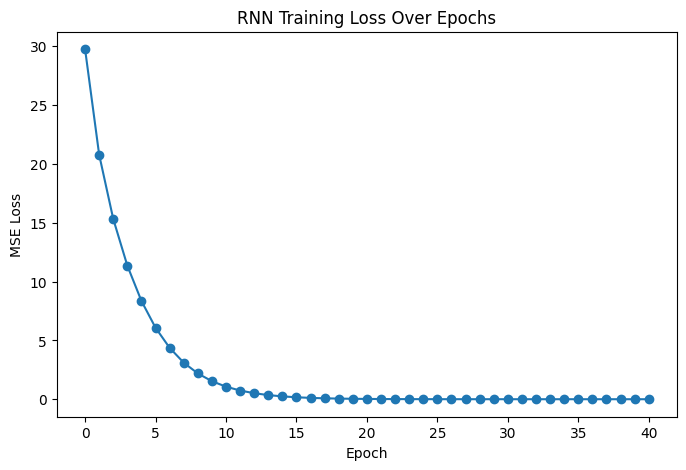

In [8]:
plt.figure(figsize=(8,5))

plt.plot(range(num_epochs),
         loss_list,
         marker='o', 
         linestyle='-')

plt.title("RNN Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(False)
plt.show()


This shows:

- Loss gradually decreases
- Model learns temporal dependency

# Final Prediction

In [9]:
pred, _ = model(sequence)
pred.item()


4.997152805328369

Interpretation:

- Output should move closer to 5
- Confirms RNN learned the sequence pattern

# Progress Flow

```
Input sequence: [1, 2, 3, 4]
Batch size: 1
Input size: 1
Hidden size: 8

Time step t=1:
   x1 = 1
   h0 = 0 (initial hidden state)
   ┌─────────────── RNN CELL ────────────────┐
   │ h1 = tanh(W_xh*x1 + W_hh*h0 + b_h)      │
   │ h1 is 8 numbers → memory after step 1   │
   └─────────────────────────────────────────┘

Time step t=2:
   x2 = 2
   h2 = tanh(W_xh*x2 + W_hh*h1 + b_h)
   ┌─────────────── RNN CELL ────────────────┐
   │ h2 is 8 numbers → remembers x1 & x2     │
   └─────────────────────────────────────────┘

Time step t=3:
   x3 = 3
   h3 = tanh(W_xh*x3 + W_hh*h2 + b_h)
   ┌─────────────── RNN CELL ────────────────┐
   │ h3 is 8 numbers → remembers x1,x2,x3    │
   └─────────────────────────────────────────┘

Time step t=4:
   x4 = 4
   h4 = tanh(W_xh*x4 + W_hh*h3 + b_h)
   ┌─────────────── RNN CELL ────────────────┐
   │ h4 is 8 numbers → remembers full seq    │
   └─────────────────────────────────────────┘

RNN LAYER:
   ┌─────────────────────────────────────────┐
   │ All cells stacked across time steps     │
   │ Hidden states: [h1, h2, h3, h4]         │
   │ Weights shared across all cells         │
   └─────────────────────────────────────────┘

Select last hidden state: h4 (summary of full sequence)

Feed h4 into Linear Layer (8 → 1):
   y_pred = W_fc * h4 + b_fc

Compare y_pred to target (5):
   loss = (y_pred - 5)^2

Backprop through time:
   - Compute gradients for W_xh, W_hh, b_h, W_fc, b_fc
   - Update all weights with optimizer

Repeat for multiple epochs:
   - Hidden states gradually encode sequence patterns
   - Prediction improves from random → 5
```

# What Happened Internally?

At each time step:
- Input enters RNN
- Hidden state updates
- Memory accumulates

After final step:
- Last hidden state summarizes the entire sequence
- Fully connected layer produces prediction

This is sequence → memory → prediction


# Why This Is Important

- This is the foundation of:
  - Language models
  - Time-series forecasting
  - Speech recognition
- LSTM & GRU are just smarter RNN cells
- Everything scales from this concept

# Key Takeaways from Day 26

- PyTorch RNN handles unrolling automatically
- Hidden state = learned memory
- Predictions often use last hidden state
- Backpropagation happens across time steps
- Vanilla RNNs work only for short sequences

---

<p style="text-align:center; font-size:18px;">
© 2026 Mostafizur Rahman
</p>
